## Data Generation

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from gwr import GWR

from sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
%matplotlib inline

from scipy.stats import norm, uniform, expon, pearsonr
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from tqdm import trange
from libpysal.weights import lat2W, Kernel

In [2]:
Nlat = 100
N = Nlat**2
D = 1
W = lat2W(Nlat, Nlat, rook=True)
W.transform = "r"
alpha_max = Nlat
alpha_min = 1

In [3]:
# Dani's spatially autocorrelated generator function
def draw_map(N, lamb, W, random_state=None):
    """
    N    = number of areal units
    lamb = parameter for how correlated it should be
    W    = spatial weights matrix
    """
    if random_state is not None: 
        np.random.seed(random_sate)

    W.transform = "r"
    e = np.random.random((N,1))
    u = np.linalg.inv(np.eye(N) - lamb * W.full()[0])
    u = np.dot(u, e)
    u = (u - u.mean()) / np.std(u)
    return u

In [4]:
W.full()[0].shape

(10000, 10000)

In [5]:
x = draw_map(N, 0.95, W).reshape((100, 100))

In [6]:
x.shape

(100, 100)

In [7]:
coords = [(i, j) for i in range(100) for j in range(100)]
coords_arr = np.array([np.array([i, j]) for i in range(100) for j in range(100)])

In [8]:
coords_arr.shape

(10000, 2)

In [9]:
x.shape

(100, 100)

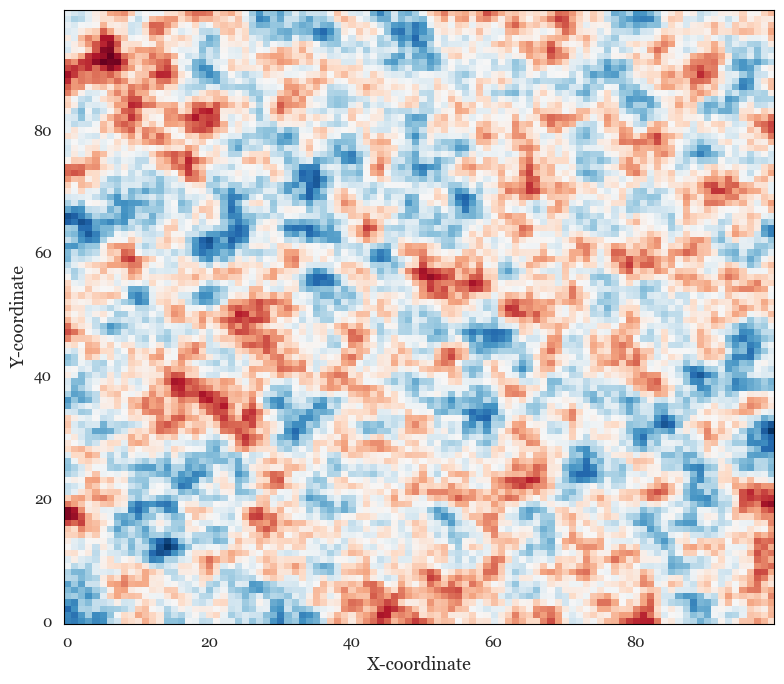

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(
    style='white',
    context='paper',   # cleaner than 'talk' for academic figs
    rc={
        'font.family': 'serif',
        'font.serif': ['Georgia'],
        'font.size': 12,
        'axes.titlesize': 18,
        'axes.titleweight': 'normal',
        'axes.labelsize': 13,
        'axes.linewidth': 0.7,
        'lines.linewidth': 0.8,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11
    }
)

# -----------------------------------------
# Create the figure
# -----------------------------------------
fig, ax = plt.subplots(figsize=(8, 7))

# Imshow surface
im = ax.imshow(
    x,
    cmap='RdBu_r',
    aspect='auto',    # or 'equal' depending on your grid
    origin='lower'    # ensures lower-left corner is (0,0)
)

# -----------------------------------------
# Title & Labels
# -----------------------------------------
# ax.set_title("X ρ = 0.95", pad=14)

# Optional axis labels (remove if not desired)
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")

# -----------------------------------------
# Graduations / tick marks
# -----------------------------------------
ax.tick_params(
    axis='both',
    which='major',
    direction='out',
    length=5,
    width=0.8,
    color='black'
)

# Light formatting for tick values (optional)
ax.locator_params(axis='both', nbins=6)

# -----------------------------------------
# Clean spines
# -----------------------------------------
for spine in ax.spines.values():
    spine.set_linewidth(0.8)
    spine.set_edgecolor('black')


# Display
# -----------------------------------------
plt.tight_layout()
plt.show()


### Split the 100 by 100 data into 4 grids each of 50 by 50

In [11]:
q1 = x[:50, :50]
q1.shape

(50, 50)

In [12]:
q2 = x[:50, 50:]
q2.shape

(50, 50)

In [13]:
q3 = x[50:, 50:]
q3.shape

(50, 50)

In [14]:
q4 = x[50:, :50]
q3.shape

(50, 50)

### Get 4 different random variables and make it correlated

In [15]:
np.random.seed(122)
X2_1 = np.random.normal(0, 1, (50, 50))
# X2_1

In [16]:
np.random.seed(233)
X2_2 = np.random.normal(0, 1, (50, 50))
# X2_2

In [17]:
np.random.seed(344)
X2_3 = np.random.normal(0, 1, (50, 50))
# X2_3

In [18]:
np.random.seed(455)
X2_4 = np.random.normal(0, 1, (50, 50))
# X2_4

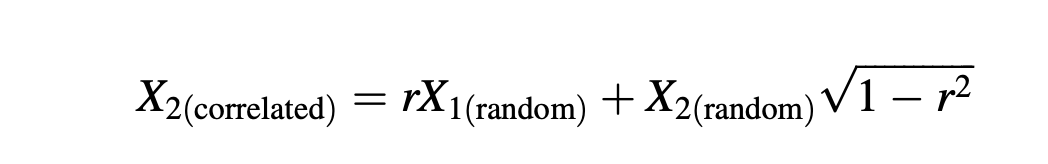

In [19]:
X2_1r = 0.3 * q1 + X2_1 * np.sqrt(1 - (0.3**2)) 

In [20]:
X2_2r = 0.5 * q2 + X2_2 * np.sqrt(1 - (0.5**2)) 

In [21]:
X2_3r = 0.7 * q3 + X2_3 * np.sqrt(1 - (0.7**2)) 

In [22]:
X2_4r = 0.9 * q4 + X2_4 * np.sqrt(1 - (0.9**2)) 

______

In [23]:
corr_coef, _ = pearsonr(X2_1r.flatten(), q1.flatten())
corr_coef

np.float64(0.31042120733634826)

In [24]:
corr_coef, _ = pearsonr(X2_2r.flatten(), q2.flatten())
corr_coef

np.float64(0.4981831802291791)

In [25]:
corr_coef, _ = pearsonr(X2_3r.flatten(), q3.flatten())
corr_coef

np.float64(0.6631034660987591)

In [26]:
corr_coef, _ = pearsonr(X2_4r.flatten(), q4.flatten())
corr_coef

np.float64(0.9139682472103692)

In [27]:
top_row = np.hstack((X2_1r, X2_2r))
bottom_row = np.hstack((X2_4r, X2_3r))
full_matrix = np.vstack((top_row, bottom_row))

print(full_matrix.shape)

(100, 100)


In [28]:
# Prepare the data
x = x.flatten()
full_matrix = full_matrix.flatten()


# Calibrate the GWR model
gwr_selector_o = Sel_BW(coords_arr, full_matrix.reshape(-1,1), x.reshape(-1,1),  constant=True, lwcc=False)
gwr_bw_o = gwr_selector_o.search(bw_min=None)
print(gwr_bw_o)
gwr_results_o = GWR(coords_arr, full_matrix.reshape(-1,1), x.reshape(-1,1), gwr_bw_o, constant=False, lwcc=False).fit()
# gwr_results_o.summary()

1134.57


In [29]:
"""
        Local collinearity formula implementation, modified for Geeographically Weighted (GW) Pearson's r. 
        Extracted from MGWR codebase,  line 1092, gwr.py, 
        __author__ = Taylor Oshan
        __modified_by__ = Victor Irekponor
"""

x_ = np.hstack((x.reshape(-1,1), full_matrix.reshape(-1,1)))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))

for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, 250)
    xw = x_[:, 0] * wi_
    yw = x_[:, 1] * wi_
    cov = np.cov(xw, yw)
    corr_mat[i] = corr(cov)[0][1]
    
corr_mat.mean(), corr_mat.min(), corr_mat.max()

(np.float64(0.5837230562432265),
 np.float64(-0.006907373669826109),
 np.float64(0.9663174381692354))

In [30]:
from scipy import stats

corr_coef, _ = stats.pearsonr(x.flatten(), full_matrix.flatten())

np.array(corr_coef).mean()

np.float64(0.6042998831832962)

In [31]:
# # Flatten variables once
# x = x.flatten()
# y = full_matrix.flatten()
# n = x.shape[0]

# corr_mat = np.empty(n)

# for i in range(n):
#     # Get kernel weights for location i
#     wi_raw = gwr_results_o.model._build_wi(i, gwr_bw_o).flatten()
    
#     # Normalize weights to sum to 1 (safe even if already normalized)
#     wi = wi_raw / wi_raw.sum()
    
#     # Local weighted means
#     x_bar_i = np.sum(wi * x)
#     y_bar_i = np.sum(wi * y)
    
#     # Local weighted deviations
#     x_dev = x - x_bar_i
#     y_dev = y - y_bar_i
    
#     # Local weighted covariance and variances
#     cov_xy_i = np.sum(wi * x_dev * y_dev)
#     var_x_i = np.sum(wi * x_dev**2)
#     var_y_i = np.sum(wi * y_dev**2)
    
#     # Local classical GWCC
#     corr_mat[i] = cov_xy_i / np.sqrt(var_x_i * var_y_i)

# # corr_mat now holds r_i^GW for the classical formulation
# print(corr_mat.mean(), corr_mat.min(), corr_mat.max())


### New Algorithm

In [32]:
# x.shape, full_matrix.shape, x_standardized.shape, y_standardized.shape

In [34]:
%timeit
# Prepare the data
x = x.flatten().reshape(-1,1)
full_matrix = full_matrix.flatten().reshape(-1,1)


# Calibrate the GWR model
gwr_selector_n = Sel_BW(coords_arr, full_matrix.reshape(-1,1), x.reshape(-1,1), constant=True, lwcc=True)
gwr_bw_n = gwr_selector_n.search(bw_min=2)
print(gwr_bw_n)
gwr_results_n = GWR(coords_arr, full_matrix.reshape(-1,1), x.reshape(-1, 1), gwr_bw_n, constant=False, lwcc=True).fit()
gwr_results_n.summary()

3980.02
Model type                                                         Gaussian
Number of observations:                                               10000
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           6438.792
Log-likelihood:                                                  -11988.164
AIC:                                                              23978.329
AICc:                                                             23980.330
BIC:                                                             -85655.402
R2:                                                                   0.365
Adj. R2:                                                              0.365

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------

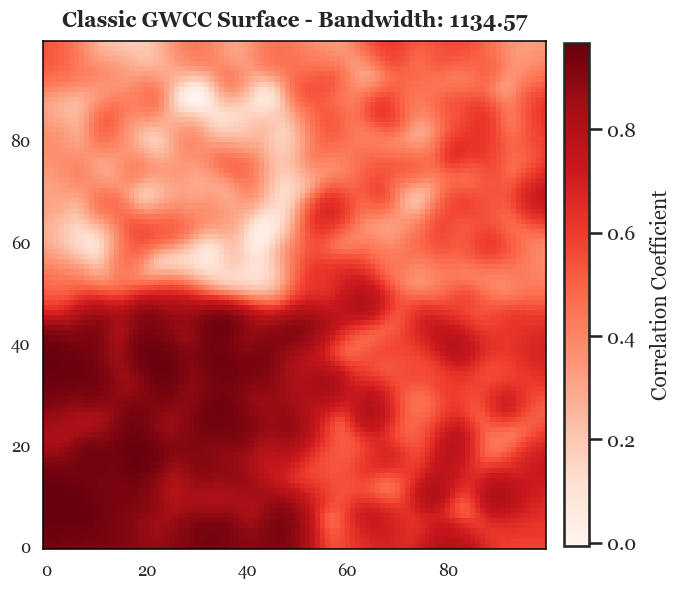

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------------------
# Apply your preferred theme
# ------------------------------
sns.set_theme(
    style='white',
    context='talk',
    rc={
        'font.family': 'serif',
        'font.serif': ['Georgia'],
        'font.size': 10,
        'axes.titleweight': 'bold',
        'axes.titlesize': 15
    }
)

# ------------------------------
# Prepare surface grid
# ------------------------------
slope = corr_mat
longitude = coords_arr[:,0].reshape(100, 100)
latitude = coords_arr[:,1].reshape(100, 100)

slope_grid = slope.reshape(100, 100)
slope_grid = np.flip(slope_grid, axis=0).T   # ensure orientation consistency

# ------------------------------
# Create improved figure
# ------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

cmap = plt.cm.Reds

# Smooth bracket for color normalization
vmin = np.nanmin(slope_grid)
vmax = np.nanmax(slope_grid)

# Plot with shading
mesh = ax.pcolormesh(
    longitude,
    latitude,
    slope_grid,
    cmap=cmap,
    shading='auto'
)

# ------------------------------
# Titles & Labels
# ------------------------------
ax.set_title(
    f"Classic GWCC Surface - Bandwidth: {gwr_bw_o}",
    pad=10
)

# Clean axis labels (optional: remove if not needed)
# ax.set_xlabel("Longitude", labelpad=10)
# ax.set_ylabel("Latitude", labelpad=10)


ax.tick_params(
    axis='both',
    which='major',
    direction='out',
    length=6,
    width=0.8,
    labelsize=12,
    color='black'
)

# ------------------------------
# Aesthetic cleanup
# ------------------------------
ax.set_facecolor("white")

# Clean but visible spines
for spine in ax.spines.values():
    spine.set_linewidth(1.1)
    spine.set_edgecolor("black")

# No ticks (cleaner for continuous surfaces)
# ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Optional (recommended): Equal aspect
# ax.set_aspect('equal')

# ------------------------------
# Add refined colorbar
# ------------------------------
cbar = fig.colorbar(mesh, ax=ax, pad=0.03, shrink=0.99)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("Correlation Coefficient", fontsize=15, labelpad=10)

# ------------------------------
# Show / Save
# ------------------------------
plt.tight_layout()
plt.show()


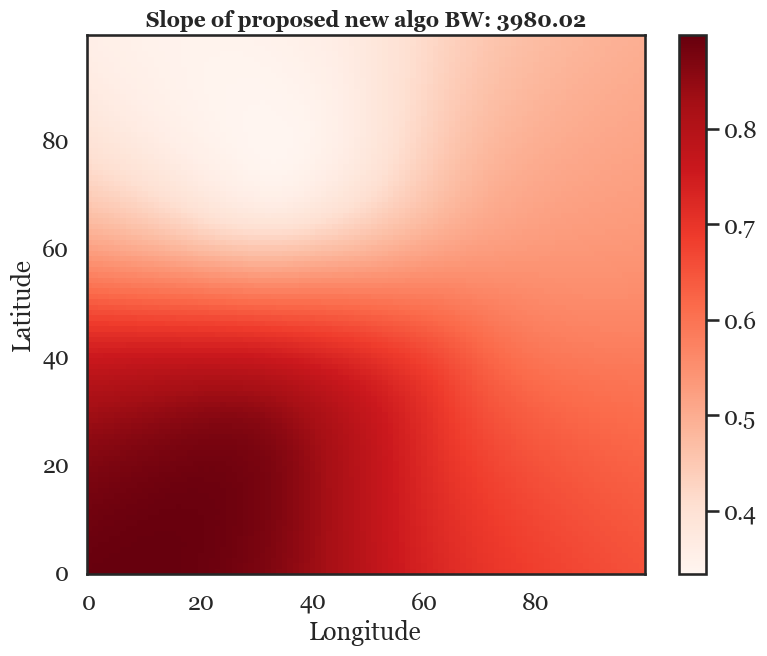

In [37]:
# Extract parameter estimates
slope = gwr_results_n.params#[:, 1]
longitude = coords_arr[:,0].reshape(100, 100)
latitude = coords_arr[:,1].reshape(100, 100)
slope_grid = slope.reshape(100,100)
slope_grid = np.flip(slope_grid, axis=0).T

# # Plot the GWR parameter estimates
fig, ax2 = plt.subplots(figsize=(9, 7))

# Plot the slope
c2 = ax2.pcolormesh(longitude, latitude, slope_grid, cmap="Reds")

# c2.set_extent([0, 100, 100, 0])
ax2.set_title(f"Slope of proposed new algo BW: {gwr_bw_n}")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

fig.colorbar(c2, ax=ax2)

plt.show()
# longitude.shape